In [2]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load Data

In [4]:
(train_ds, test_ds), info = tfds.load('ag_news_subset', split=['train', 'test'],
                                      shuffle_files=True, as_supervised=True, with_info=True)

# Cleaning Data

In [5]:
def clean_text(text):
    """
    Cleans a raw text string by lowercasing, removing punctuation/numbers,
    tokenizing, and removing stopwords.

    Args:
        text (str): The input raw text string.

    Returns:
        str: The cleaned and normalized text string.
    """
    text = text.lower()                                 # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)                # Remove punctuation/numbers
    tokens = text.split()                               # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

In [6]:
def tf_clean_text(text, label):
    """
    TensorFlow-compatible wrapper for text cleaning. Accepts a tf.Tensor input,
    decodes it, applies `clean_text()`, and returns the cleaned text as a tf.string.

    Args:
        text (tf.Tensor): The input text tensor (dtype=tf.string).
        label (tf.Tensor): Corresponding label tensor (passed through unchanged).

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: Cleaned text tensor and original label.
    """
    clean = tf.py_function(func=lambda x: clean_text(x.numpy().decode("utf-8")),
                           inp=[text],
                           Tout=tf.string)
    clean.set_shape([])  
    return clean, label

### Apply cleaning functions on train and test datasets

In [7]:
clean_train_ds = train_ds.map(tf_clean_text)
clean_test_ds = test_ds.map(tf_clean_text)

# Exploratory Data Analysis

In [8]:
def generate_wordclouds(dataset, file_name):
    """
    Generates and saves word clouds for each class in a text classification dataset.

    This function iterates over the dataset, groups text samples by their label,
    and creates a word cloud for each category. The resulting figure is saved to a file.

    Args:
        dataset (Iterable): A dataset of (text, label) pairs. Each `text` should be a tf.Tensor or bytes,
                            and `label` should be a numeric class index.
        file_name (str): Path to save the final word cloud plot image (e.g., 'wordclouds.png').

    Returns:
        None. Displays and saves a matplotlib figure with 4 subplots (one per class).
    """
    category_texts = {i: [] for i in range(4)}
    for text, label in dataset:
        # Convert label to a hashable type (e.g., int)
        category_texts[label.numpy().item()].append(text.numpy().decode('utf-8')) # Changed line

    # Generate and plot wordclouds
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        combined_text = ' '.join(category_texts[i])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
        axs[i].imshow(wordcloud, interpolation='bilinear')
        # Assuming CATEGORY_NAMES is defined elsewhere
        axs[i].set_title(info.features['label'].names[i])  
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

In [9]:
def plot_distribution(data, filename, title="Data Distribution", ylabel="Frequency"):
    """
    Plots the distribution of class labels in a dataset and optionally saves the plot.

    Args:
        data (Iterable): A dataset of (text, label) pairs where `label` is a tf.Tensor or integer-encoded class.
        title (str): Title of the plot. Default is "Data Distribution".
        ylabel (str): Label for the y-axis. Default is "Frequency".
        filename (str): Path to save the plot image (e.g., 'label_distribution.png'). If "None", plot is not saved.

    Returns:
        None. Displays a seaborn bar plot of class frequencies and optionally saves it to a file.
    """
    
    labels = [label.numpy().item() for _, label in data]
    counts = Counter(labels)
    
    # Convert to label names
    category_names = [info.features['label'].names[i] for i in sorted(counts)]
    frequencies = [counts[i] for i in sorted(counts)]

    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=category_names, y=frequencies, palette="pastel", edgecolor="black", width=0.5)
    plt.title(title)
    plt.xlabel("Category")
    plt.ylabel(ylabel)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
    plt.savefig(filename)
    plt.close()

#### Word Cloud for Training Dataset

2025-04-24 20:27:33.446608: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-24 20:27:49.881841: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


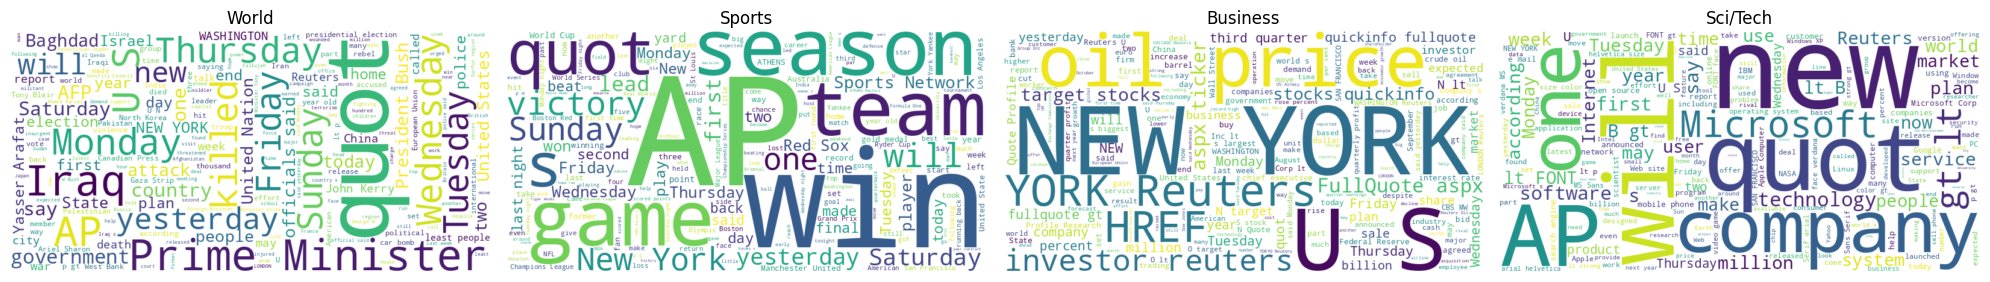

In [10]:
generate_wordclouds(train_ds, 'training_wordclouds.png')

#### Word Cloud for Test Dataset

2025-04-24 20:28:16.009623: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


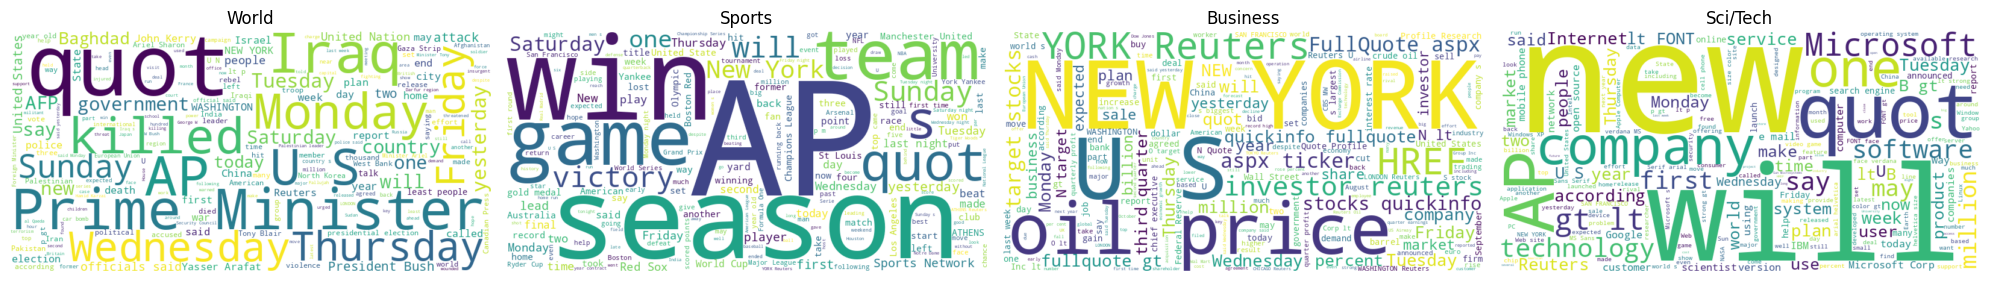

In [11]:
generate_wordclouds(train_ds, 'test_wordclouds.png')

#### Word Cloud for Cleaned Training Dataset

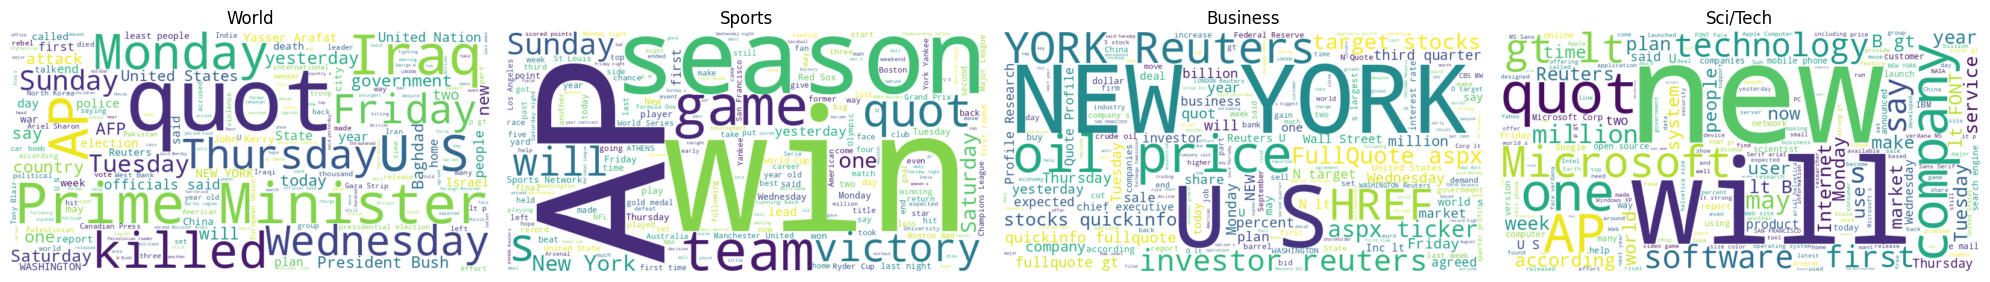

In [12]:
generate_wordclouds(train_ds, 'cleaned_training_wordclouds.png')

#### Word Cloud for Cleaned Test Dataset

2025-04-24 20:29:09.709451: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


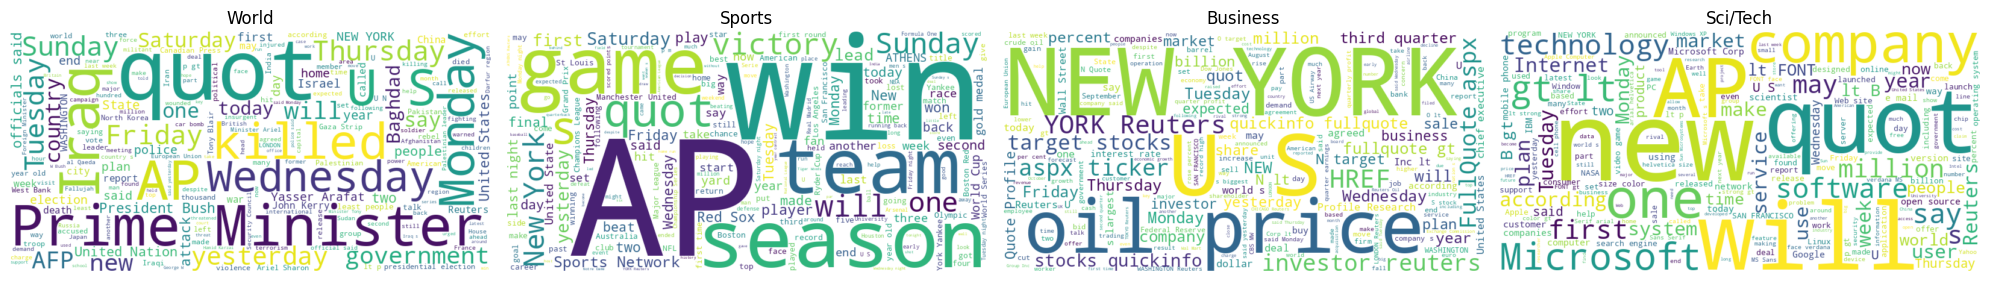

In [13]:
generate_wordclouds(train_ds, 'cleaned_test_wordclouds.png')

#### Checking balance (Training Dataset)

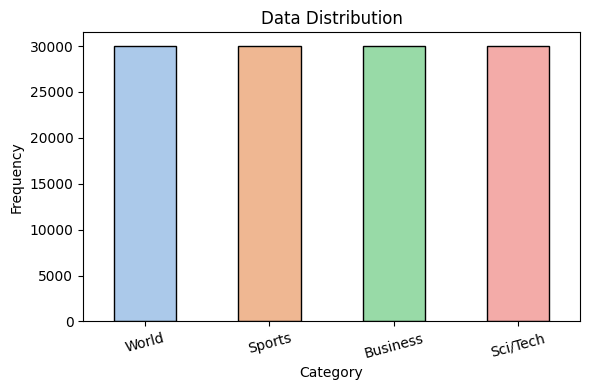

In [14]:
plot_distribution(train_ds, 'training_dist.png')

#### Checking balance (Test Dataset)

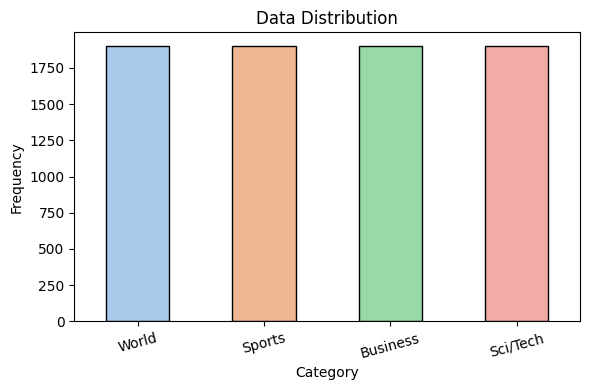

In [15]:
plot_distribution(test_ds, 'test_dist.png')

# Preprocessing

In [37]:
def preprocess(text, label):
    """
    Tokenizes the input text and one-hot encodes the label.

    Args:
        text (tf.Tensor or str): The input text to be tokenized.
        label (tf.Tensor or int): The integer label to be one-hot encoded.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple containing:
            - tokenized text tensor (e.g., sequence of word indices)
            - one-hot encoded label tensor with depth 4
    """
    return tokenizer(text), tf.one_hot(label, depth=4)

In [38]:
tokenizer = tf.keras.layers.TextVectorization(max_tokens=10000, output_sequence_length=128)

# Adapt tokenizer on train text
text_ds = train_ds.map(lambda text, label: text)
tokenizer.adapt(text_ds)

train_tokenized = train_ds.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)
test_tokenized = test_ds.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)

2025-04-24 21:13:54.610182: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Building LSTM+Attention and GRU+Attention Models

### Customer Attention layer

In [45]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    """
    Implements the Scaled Dot-Product Attention mechanism.

    This layer computes attention scores using the dot product of queries and keys,
    scales the scores, applies a softmax to obtain attention weights, and finally
    uses them to compute a weighted sum of the values.

    Attributes:
        Inherits from tf.keras.layers.Layer.
    """

    def __init__(self):
        """Initializes the attention layer without additional parameters."""
        super().__init__()

    def call(self, q, k, v, mask=None):
        """
        Applies scaled dot-product attention.

        Args:
            q (tf.Tensor): Query tensor of shape (..., seq_len_q, depth)
            k (tf.Tensor): Key tensor of shape (..., seq_len_k, depth)
            v (tf.Tensor): Value tensor of shape (..., seq_len_v, depth_v)
            mask (tf.Tensor, optional): Float tensor broadcastable to (..., seq_len_q, seq_len_k)
                                        with -inf (or large negative) values where masking is applied.

        Returns:
            tf.Tensor: The result of attention with shape (..., seq_len_q, depth_v)
        """
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        d_k = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_logits = matmul_qk / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output


## LSTM Model

In [46]:
class LSTMAttentionModel(tf.keras.Model):
    """
    A Bidirectional LSTM model with Scaled Dot-Product Attention for text classification.

    The model architecture includes:
    - An Embedding layer to convert token indices into dense vectors
    - A Bidirectional LSTM to capture contextual information from both directions
    - Scaled Dot-Product Attention mechanism to emphasize relevant parts of the sequence
    - Global average pooling over the attention output
    - A Dense output layer with softmax activation for classification

    Args:
        vocab_size (int): Size of the vocabulary (input dimension for the embedding layer).
        embed_dim (int): Dimension of word embeddings.
        hidden_dim (int): Number of units in the LSTM (per direction).
        num_classes (int): Number of output classes for classification.
    """

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.bi_lstm = tf.keras.layers.Bidirectional(
            layer=tf.keras.layers.LSTM(
                hidden_dim,
                return_sequences=True))
        self.q_proj = tf.keras.layers.Dense(hidden_dim)
        self.k_proj = tf.keras.layers.Dense(hidden_dim)
        self.v_proj = tf.keras.layers.Dense(hidden_dim)
        self.attention = ScaledDotProductAttention()
        self.pooling = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        """
        Forward pass for the model.

        Args:
            x (tf.Tensor): Input tensor of token indices with shape (batch_size, sequence_length).

        Returns:
            tf.Tensor: Output probability distribution over classes with shape (batch_size, num_classes).
        """
        x = self.embedding(x)
        x = self.bi_lstm(x)
        q, k, v = self.q_proj(x), self.k_proj(x), self.v_proj(x)
        x = self.attention(q, k, v)
        x = self.pooling(x)
        return self.classifier(x)


## GRU Model

In [47]:
class GRUAttentionModel(tf.keras.Model):
    """
    A Bidirectional GRU model with Scaled Dot-Product Attention for text classification.

    This model processes input sequences using:
    - An embedding layer to convert token indices into dense vector representations
    - A bidirectional GRU layer to capture contextual dependencies from both directions
    - Scaled dot-product attention to focus on the most relevant parts of the sequence
    - Global average pooling to aggregate features across the sequence
    - A dense output layer with softmax activation for multi-class classification

    Args:
        vocab_size (int): Size of the vocabulary (input dimension for the embedding layer).
        embed_dim (int): Dimension of the embedding vectors.
        hidden_dim (int): Number of units in the GRU (per direction).
        num_classes (int): Number of output classes.
    """

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.bi_gru = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(hidden_dim, return_sequences=True))
        self.q_proj = tf.keras.layers.Dense(hidden_dim)
        self.k_proj = tf.keras.layers.Dense(hidden_dim)
        self.v_proj = tf.keras.layers.Dense(hidden_dim)
        self.attention = ScaledDotProductAttention()
        self.pooling = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        """
        Forward pass of the GRU-Attention model.

        Args:
            x (tf.Tensor): Input tensor of token indices with shape (batch_size, sequence_length).

        Returns:
            tf.Tensor: Output class probabilities with shape (batch_size, num_classes).
        """
        x = self.embedding(x)
        x = self.bi_gru(x)
        q, k, v = self.q_proj(x), self.k_proj(x), self.v_proj(x)
        x = self.attention(q, k, v)
        x = self.pooling(x)
        return self.classifier(x)

## Compiling and fitting the models

### Early Stopping to avoid the over-fitting

In [53]:
early_stop = EarlyStopping(
    monitor='val_loss',        
    patience=3,                
    restore_best_weights=True)

EPOCHS = 10
EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_CLASS = 4
VOCAB_SIZE = 10000

### Training LSTM+Attention

In [54]:
model_lstm = LSTMAttentionModel(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASS)
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.build(input_shape=(None, 128))
history_lstm = model_lstm.fit(train_tokenized, epochs=EPOCHS, validation_data=test_tokenized, callbacks=[early_stop])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 396s 210ms/step - accuracy: 0.7709 - loss: 0.5478 - val_accuracy: 0.9003 - val_loss: 0.2911
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 392s 209ms/step - accuracy: 0.9185 - loss: 0.2364 - val_accuracy: 0.8991 - val_loss: 0.2896
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 392s 209ms/step - accuracy: 0.9362 - loss: 0.1840 - val_accuracy: 0.8950 - val_loss: 0.3442
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 391s 209ms/step - accuracy: 0.9544 - loss: 0.1339 - val_accuracy: 0.8850 - val_loss: 0.4703
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 392s 209ms/step - accuracy: 0.9661 - loss: 0.0949 - val_accuracy: 0.8807 - val_loss: 0.5715


#### Summary of model and save 

In [55]:
model_lstm.save("lstm_attention_model.keras")
model_lstm.save_weights("lstm_attention.weights.h5")
model_lstm.summary()

Model: "lstm_attention_model_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 128, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_dot_product_attention_8  │ ?                      │             0 │
│ (ScaledDotProductAttention)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,927,118 (18.80 MB)

 Trainable params: 1,642,372 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,284,746 (12.53 MB)

### Training GRU+Attention

In [56]:
model_gru = GRUAttentionModel(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASS)
model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_gru = model_gru.fit(train_tokenized, epochs=EPOCHS, validation_data=test_tokenized, callbacks=[early_stop])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 374s 198ms/step - accuracy: 0.7528 - loss: 0.5824 - val_accuracy: 0.9022 - val_loss: 0.2893
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 370s 197ms/step - accuracy: 0.9189 - loss: 0.2346 - val_accuracy: 0.9009 - val_loss: 0.2946
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 370s 197ms/step - accuracy: 0.9357 - loss: 0.1848 - val_accuracy: 0.8932 - val_loss: 0.3456
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 370s 197ms/step - accuracy: 0.9527 - loss: 0.1361 - val_accuracy: 0.8826 - val_loss: 0.4511


#### Summary of model and save 

In [57]:
model_gru.save("gru_attention_model.keras")
model_gru.save_weights("gru_attention.weights.h5")
model_gru.summary()

Model: "gru_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 128, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 128, 256)       │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_dot_product_attention_9  │ ?                      │             0 │
│ (ScaledDotProductAttention)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,732,046 (18.05 MB)

 Trainable params: 1,577,348 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,154,698 (12.03 MB)

# Monitor Training Process

In [58]:
def plot_training_history(history, title, filename=None):
    """
    Plots training and validation accuracy and loss over epochs from a Keras training history.

    Args:
        history (tf.keras.callbacks.History): The training history object returned by model.fit().
        title (str): Title prefix for the subplots (e.g., model name).
        filename (str, optional): If provided, the plot will be saved to this file path (e.g., 'training_plot.png').

    Returns:
        None. Displays a 1x2 subplot figure with accuracy and loss curves and optionally saves it.
    """
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy subplot
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Test Accuracy')
    axs[0].set_title(f'{title} - Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(False)

    # Loss subplot
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Test Loss')
    axs[1].set_title(f'{title} - Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(False)

    plt.tight_layout()
    plt.show()

    
    fig.savefig(filename)
    plt.close(fig)

#### LSTM Training Process

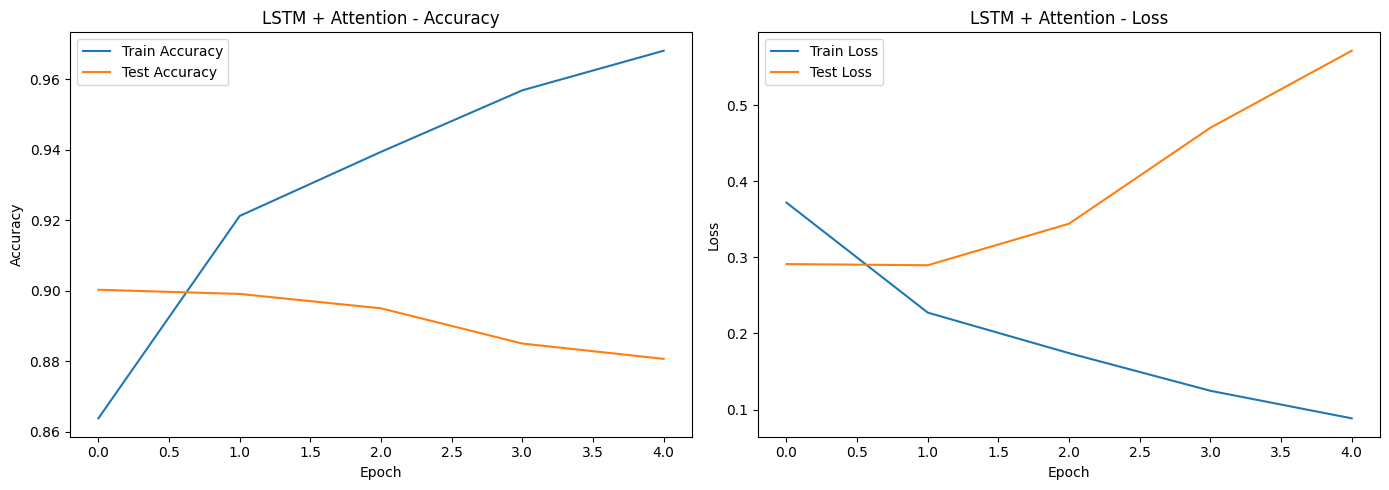

In [59]:
plot_training_history(history_lstm, 'LSTM + Attention', 'lstm_attention.png')

#### GRU Training Process

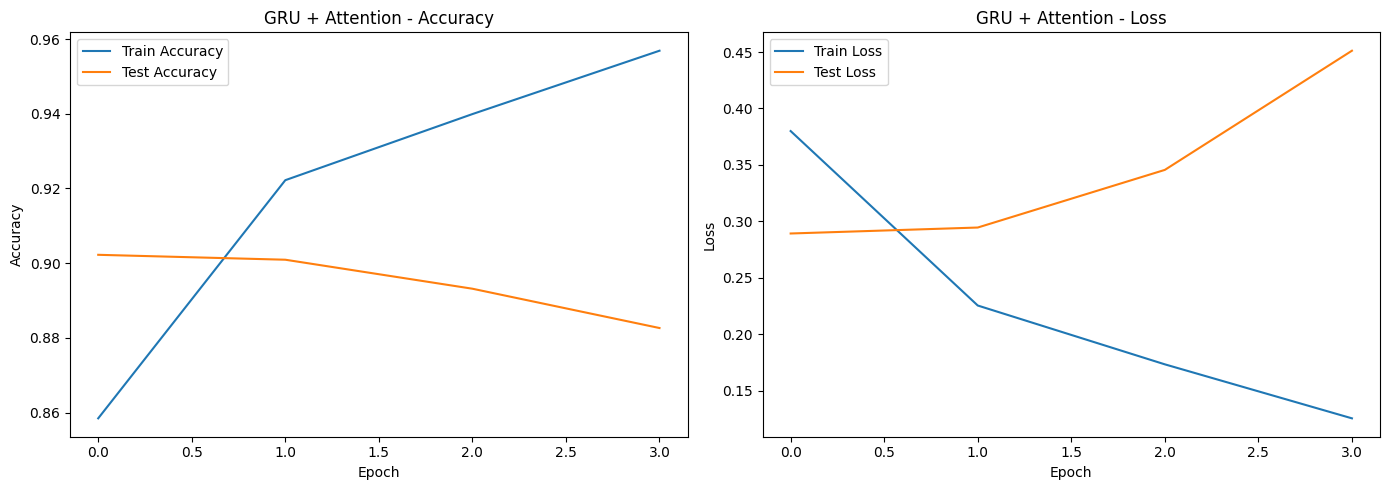

In [60]:
plot_training_history(history_gru, 'GRU + Attention', 'gru_attention.png')

# Evaliuation

In [61]:
def confusion_matrix_plot(model, data, filename=None, class_names=None):
    """
    Computes and plots the confusion matrix for a classification model.

    Args:
        model (tf.keras.Model): Trained Keras model used for prediction.
        data (tf.data.Dataset): Batched dataset of (X, y) pairs.
                                `y` is assumed to be one-hot encoded.
        class_names (list of str, optional): List of class labels to display. 
                                             Defaults to ["World", "Sports", "Business", "Sci/Tech"].
        filename (str, optional): If provided, saves the plot to this file (e.g., 'confusion_matrix.png').

    Returns:
        None. Displays and optionally saves the confusion matrix plot.
    """
    y_true = []
    y_pred = []

    for x_batch, y_batch in data:
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)

    if class_names is None:
        class_names = ["World", "Sports", "Business", "Sci/Tech"]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")

    plt.title("Confusion Matrix")
    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        print(f"Confusion matrix saved to {filename}")

    plt.show()
    plt.close()

### Confusion Matrix for Test data using LSTM + Attention

Confusion matrix saved to Confusion_matrix_LSTM+Attention.png


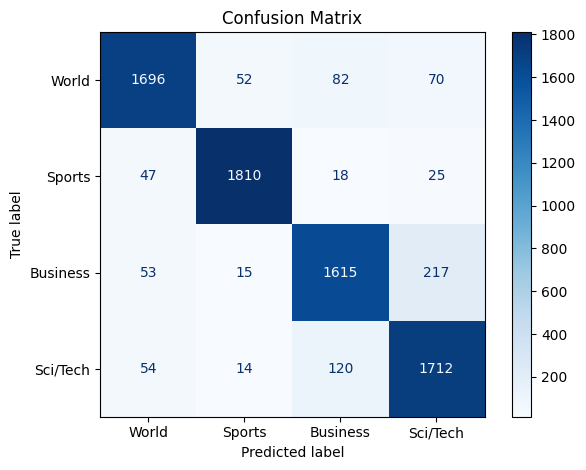

In [62]:
confusion_matrix_plot(model_lstm, test_tokenized, 'Confusion_matrix_LSTM+Attention.png')

### Confusion Matrix for Test data using GRU + Attention

Confusion matrix saved to Confusion_matrix_GRU+Attention.png


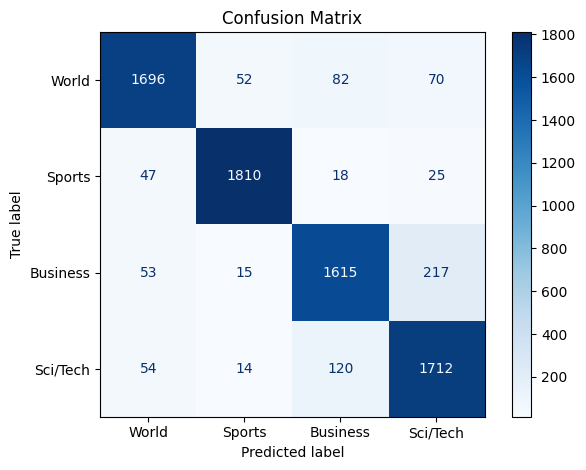

In [63]:
confusion_matrix_plot(model_lstm, test_tokenized, 'Confusion_matrix_GRU+Attention.png')